# ToiFall: WiFi CSI Activity Recognition

## Introduction 

Falls in restrooms and bathrooms can lead to severe injuries and even pose life threats to patients. ToiFall project collects Channel State Information (CSI) from commodity Wi-Fi devices. Channel State Information indicates the Wi-Fi signal channel properties (frequency response) over time, which is leveraged initially to improve Wi-Fi communication qualities.

As part of the indoor channel, the human body reflects and deflects the Wi-Fi signals, and then the CSI is affected by human activities. Different human movements form various textures on images drawn with CSI data, and such textures can be used for feature extraction and classification.

This dataset consists of 1750 pictures collected from 17 volunteers, who are asked to perform one of the six frequent movements in restrooms. These movements are illustrated in the figure below: walk, stand up, sit down, fall to the left, fall to the right, and fall to the front. 

![1.png](https://i.loli.net/2021/07/14/7CVvd5aGHyYTu9x.png)

For more information, please refer to the following publication:

[1] Wang, Ziqi, Zhihao Gu, Junwei Yin, Zhe Chen, and Yuedong Xu. "Syncope detection in toilet environments using Wi-Fi channel state information." In Proceedings of the 2018 ACM International Joint Conference and 2018 International Symposium on Pervasive and Ubiquitous Computing and Wearable Computers, pp. 287-290. 2018.

The ToiFall dataset is available at:

https://drive.google.com/file/d/1RJvLL58m__km6vPTZbW2IV3FqgplvOj4/view?usp=sharing

Other References:

[2]Gabor Filter - Wikipedia: https://en.wikipedia.org/wiki/Gabor_filter

[3]Gabor filter banks for texture classification: Haghighat, Mohammad, Saman Zonouz, and Mohamed Abdel-Mottaleb. "Identification using encrypted biometrics." In International Conference on Computer Analysis of Images and Patterns, pp. 440-448. Springer, Berlin, Heidelberg, 2013.

This project consists of the following steps:
Load pre-processed dataset -> Gabor Filter feature extraction -> SVM Classification

In [ ]:
!pip install numpy
!pip install scipy
!pip install matplotlib
!pip install opencv-python
!pip install tqdm
!pip install pandas
!pip install scikit-image
!pip install scikit-learn

## Load and Prepare Dataset

Download the preprocessed dataset from the link below, then upload the zip file to your Google Drive:
https://drive.google.com/file/d/1RJvLL58m__km6vPTZbW2IV3FqgplvOj4/view?usp=sharing

Each image in the dataset is collected from two WiFi links when some activity is performed.

In [ ]:
# Mount Google Drive and unzip the dataset
from google.colab import drive
drive.mount('/content/gdrive')
!unzip "/content/gdrive/MyDrive/toifall_dataset.zip" -d "/content/gdrive/MyDrive/toifall_dataset/"

Min value in this geryscale image is 0
Max value in this geryscale image is 255


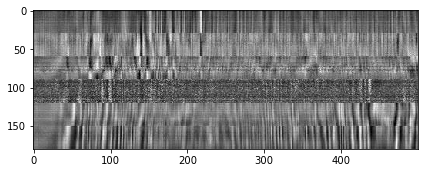

In [1]:
# open a sample image
from skimage import io
import numpy as np
img = io.imread("/content/gdrive/MyDrive/toifall_dataset/walk/walk_077.jpg")
io.imshow(img)
print("Min value in this geryscale image is {}".format(np.min(img)))
print("Max value in this geryscale image is {}".format(np.max(img)))

**The data has already gone through the following pre-processing.** The information below is just to provide you with some background information to help you understand the full scale of this project. It is **not** related to the algorithm coding tasks that you are going to finish.

(1) Channel State Information from all the 180 channels is juxtaposed to form a (180 * timestamp) size matrix. The 180 channels are 2 WiFi links x 3 Antennas/Link x 30 Subcarriers/Antenna.

(2) Each data point is a complex number. We first extract the amplitude of CSI data. Then we apply a 10-order Butterworth filter with a cutoff frequency of 40Hz on each channel to remove the high-frequency noise.

(3) We calculate the signal variance within a sliding window of 500 points and segment out the section with the highest variance -- they are more likely to be related to human activities.

(4) We further enhance the signal by removing the static frequency response caused by the indoor environment. This is achieved by performing an SVD decomposition of the data matrix, then reconstructing the data matrix with the first eigenvalue set to zero.

Label: fall_forward


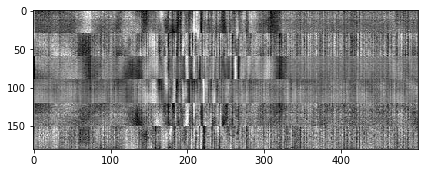

In [4]:
# load the dataset into memory
import os
activity = ["empty", "fall_forward", "fall_left", "fall_right", "sit", "stand", "walk"]
data = []
label = []
for i in range(len(activity)):
    path = "/content/gdrive/MyDrive/toifall_dataset/" + activity[i]
    dir_list = os.listdir(path)
    cnt = 0
    for each in dir_list:
        img_path = path + "/" + each
        data.append(io.imread(img_path))
        label.append(i)
        cnt += 1
        if cnt >= 100: # reduce the number if the feature extraction take too long to execute
            cnt=0
            # break # if comment out the break: load the whole dataset to memory

# open an example
data = np.array(data)
label = np.array(label)
io.imshow(data[277])
print("Label: {}".format(activity[label[277]]))

In [5]:
data.shape
# (7xN, 180, 500), N of your choice

(1750, 180, 500)

## Gabor Filter Feature Extraction

In this section, we are going to extract the feature from the images using Gabor filter. Gabor filters have been widely used in pattern analysis applications. The most important advantage of Gabor filters is their invariance to illumination, rotation, scale, and translation. [3]

Here we will privide you with a high-level non-precise intuition about this feature extraction process. A typical group of Gabor filter kernels is shown in (b) below. It looks like a number of stripes with different scales and orientations. 

![2.png](https://i.loli.net/2021/07/14/Zn3q9pVOmCLhUk1.png)

We will do a cross-correlation between each image and each kernels. From Project 1 we already know that the resulting value will be higher if the image region being calculated looks alike the template. In this case, the Gabor filter kernels servers as the template. Different iamges will react differntly to different kernels. For example, if the image of walking contains a lot of wide vertical stripes, when calcuating correlation with a kernal looking similar, the average value will be large. In this way, the "reaction" of the image w.r.t to different kernels can serve as a feature for future classification. See the example below, the figures in this block come from [3].

![3.png](https://i.loli.net/2021/07/14/lfCTIDiF5cm4R1U.png)

**Now it is time to implement you own *gaborFilterBank* with different scales and orientations.** Please follow the following equation:

![4.png](https://i.loli.net/2021/07/14/Iv3iP8sVtlxwTkH.png)

,where

![5.png](https://i.loli.net/2021/07/14/tQUvG9WVBzgmLpx.png)

![6.png](https://i.loli.net/2021/07/14/aHnTeg79DQcGMvu.png)

![7.png](https://i.loli.net/2021/07/14/f96ixI2zZHdWLGK.png)

$f$ is related to the scales, where we start from $f_0 = 0.25$, then for the next scales, $f_1 = \frac{0.25}{\sqrt 2}$, $f_2 = \frac{0.25}{(\sqrt 2)^2}$, $f_3 = \frac{0.25}{(\sqrt 2)^3}$, so on so forth.

$\theta$ is related to the orientations, where $\theta_i = \frac{i}{number\_of\_orientations} \times \pi $

($x_0$, $y_0$) is the center point of a kernel. For example, if the size of the kernel is 15x15, then $x_0 = y_0 = 7$.

In [6]:
# prepare filter bank kernels
def gaborFilterBank(u=8, v=6, m=15, n=15):
    '''   
    Inputs:
           u: No. of scales (usually set to 8) 
           v: No. of orientations (usually set to 6)
           m: No. of rows in a 2-D Gabor filter (an odd integer number usually set to 15)
           n: No. of columns in a 2-D Gabor filter (an odd integer number usually set to 39)

    Output:
           gaborArray: A 1D array of size (u x v), in which each element is a m by n matrix 
                                                                                    (a 2-D Gabor filter)   
    '''
    assert m%2 != 0
    assert n%2 != 0
    gaborArray = []
    
    fmax = 0.25;
    gama = np.sqrt(2);
    eta = np.sqrt(2);
    
    ##########################################################

    # Your code here

    ##########################################################

    return np.array(gaborArray)

In [7]:
# Generate Gabor Filter Kernels
kernels = gaborFilterBank()

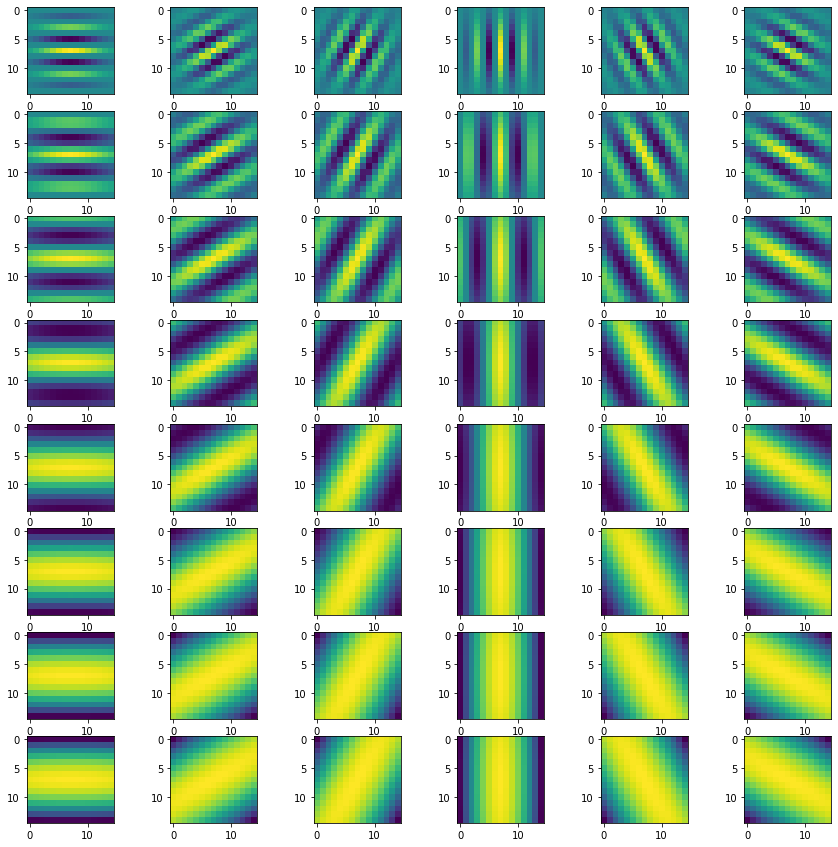

In [8]:
# Visualize the generated kernels
import matplotlib.pyplot as plt
fig, axs = plt.subplots(nrows=8, ncols=6, figsize=(15,15))
for i in range(8):
    for j in range(6):
        axs[i][j].imshow(np.real(kernels[i*6+j]))
plt.show()

Compare your results with this one:
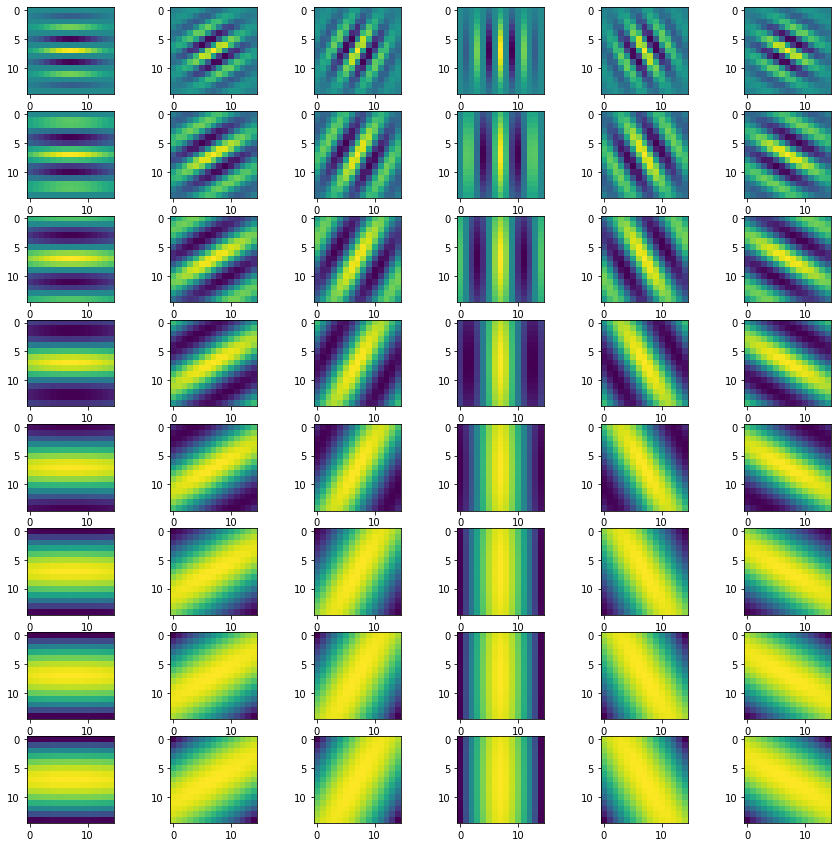

In [14]:
from tqdm import tqdm
from scipy import signal
from scipy.ndimage import correlate
processed_data = []

def compute_feats(image, kernels):
    # compute cross-corr of one image with all the Gabor kernels
    feats = np.zeros((len(kernels), 2), dtype=np.double)
    for k, kernel in enumerate(kernels):
        # filtered  = np.abs(signal.correlate2d(image, kernel, mode='valid'))
        filtered  = np.abs(correlate(image, kernel, mode='constant'))
        feats[k, 0] = filtered.mean()
        feats[k, 1] = filtered.std()
    return feats

result = np.zeros((row_bound, col_bound))

# Extract features from each element of the dataset
processed_data = []
for each_img in tqdm(data):
    feats = compute_feats(each_img, kernels)
    processed_data.append(np.array(feats).flatten())

print(np.shape(processed_data))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1750/1750 [44:20<00:00,  1.52s/it]

(1750, 96)


In [15]:
print(processed_data[0])

[3.91597748 2.11923194 2.0687201  1.16981447 2.06202507 1.19645178
 3.47251177 1.85186076 2.00971913 1.15674853 2.0960815  1.18114114
 5.59940434 1.90724611 1.42880809 0.79977983 1.48070049 0.80650699
 5.48576546 1.83196354 1.4708873  0.81221592 1.44220412 0.80377573
 3.85822558 1.4585036  1.5195905  0.76188421 1.56369603 0.79549086
 3.75045061 1.32230246 1.56850362 0.78778964 1.51670659 0.76488024
 4.86464739 1.20190096 1.38871801 0.73252016 1.44289613 0.73767394
 4.94348335 1.27298892 1.46264529 0.75062132 1.40324032 0.74769706
 1.77860117 1.0200026  2.75385523 0.75641906 2.71475863 0.74104673
 1.76433337 0.88130093 2.72871494 0.77204621 2.76512456 0.78735697
 3.51495552 0.61622339 3.70376945 0.62209487 3.68276811 0.65462631
 3.47481632 0.66797018 3.68654728 0.67031717 3.70726776 0.63826728
 2.77755475 0.45760238 2.80440164 0.46520963 2.79754138 0.47901878
 2.7639575  0.48446414 2.79860425 0.48380163 2.80542922 0.47007629
 1.70021462 0.28571942 1.70335329 0.2877492  1.70141351 0.2919

In [17]:
print(processed_data[300])

[3.09702229 1.63105583 1.23794675 0.89426011 1.22119403 0.85261345
 4.45419216 3.05166698 1.22458386 0.89643306 1.24577498 0.88394082
 5.22154188 1.51492512 1.00914526 0.69832528 1.08596289 0.79874867
 6.0831213  2.90371966 1.05134618 0.75894022 0.98356217 0.65425408
 3.64219022 1.20784152 1.42989981 0.74135852 1.58410394 0.8844682
 4.35319185 2.32200217 1.57980192 0.90829748 1.41785216 0.7439667
 4.6966095  1.12274551 1.3149426  0.67980701 1.62187982 0.93860388
 4.9855051  1.78882802 1.6162554  0.95818257 1.32893455 0.69631064
 1.68555331 0.88982272 2.65829158 0.7110284  2.69763327 0.90183854
 1.8986429  1.12210691 2.69258118 0.90190214 2.65753984 0.71611142
 3.38746071 0.59834915 3.57915831 0.64086699 3.57738614 0.72249395
 3.38605595 0.75680184 3.57610393 0.71999568 3.57832074 0.63951331
 2.681427   0.47007313 2.71025157 0.48523027 2.70863986 0.50827885
 2.67827249 0.51600718 2.70827699 0.50740081 2.7099452  0.48451331
 1.64231801 0.29629534 1.64615691 0.30002433 1.64560378 0.306071

## SVM Classification

In [18]:
# Prepare training-testing datasets for SVM

# Normalize the extracted features
processed_data = np.array(processed_data)
for i in range(len(processed_data)):
     processed_data[i] = (processed_data[i] - np.min(processed_data[i]))/ (np.max(processed_data[i]) 
                                                                         - np.min(processed_data[i]))

# Split the data into training and testing set
from sklearn.model_selection import StratifiedShuffleSplit
stratSplit = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=0)
for train_idx, test_idx in stratSplit.split(processed_data, label):
    X_train=processed_data[train_idx]
    y_train=label[train_idx]
    X_test=processed_data[test_idx]
    y_test=label[test_idx]

print(np.shape(X_train))
print(np.shape(X_test))
print(np.shape(y_train))
print(np.shape(y_test))
print(np.unique(y_train, return_counts=True))
print(np.unique(y_test, return_counts=True))

(1312, 96)
(438, 96)
(1312,)
(438,)
(array([0, 1, 2, 3, 4, 5, 6]), array([187, 188, 188, 187, 187, 187, 188]))
(array([0, 1, 2, 3, 4, 5, 6]), array([63, 62, 62, 63, 63, 63, 62]))


In [19]:
processed_data[0]

array([6.83190312e-01, 3.45054806e-01, 3.35548816e-01, 1.66380781e-01,
       3.34288855e-01, 1.71393745e-01, 5.99733028e-01, 2.94737336e-01,
       3.24445227e-01, 1.63921859e-01, 3.40698047e-01, 1.68512384e-01,
       1.00000000e+00, 3.05160489e-01, 2.15121651e-01, 9.67427344e-02,
       2.24887454e-01, 9.80087408e-02, 9.78613922e-01, 2.90992812e-01,
       2.23040677e-01, 9.90831238e-02, 2.17642693e-01, 9.74947352e-02,
       6.72321792e-01, 2.20710147e-01, 2.32206292e-01, 8.96110319e-02,
       2.40506659e-01, 9.59355786e-02, 6.52039262e-01, 1.95078002e-01,
       2.41411415e-01, 9.44862608e-02, 2.31663560e-01, 9.01748643e-02,
       8.61723651e-01, 1.72419244e-01, 2.07576965e-01, 8.40849140e-02,
       2.17772925e-01, 8.50548200e-02, 8.76560053e-01, 1.85797522e-01,
       2.21489585e-01, 8.74914306e-02, 2.10309967e-01, 8.69411037e-02,
       2.80950371e-01, 1.38187189e-01, 4.64486669e-01, 8.85825272e-02,
       4.57128951e-01, 8.56895563e-02, 2.78265266e-01, 1.12084460e-01,
      

In [26]:
# Train the SVM classifier
from sklearn import datasets, svm, metrics
clf = svm.SVC(C=10, kernel="poly", degree=6)
clf.fit(X_train, y_train)

# Make predictions with the trained SVM classifier
predicted = clf.predict(X_test)

In [27]:
predicted

array([6, 3, 2, 2, 6, 4, 2, 3, 3, 5, 4, 2, 2, 0, 0, 4, 3, 0, 6, 1, 3, 0,
       1, 3, 1, 2, 3, 4, 0, 4, 4, 2, 0, 3, 4, 2, 1, 6, 2, 4, 5, 1, 2, 6,
       6, 0, 2, 0, 2, 2, 6, 2, 2, 0, 0, 1, 2, 2, 5, 1, 1, 3, 0, 1, 6, 0,
       5, 0, 2, 1, 0, 3, 1, 4, 1, 5, 4, 4, 3, 0, 4, 4, 1, 0, 6, 2, 5, 0,
       5, 3, 5, 2, 0, 0, 0, 0, 3, 1, 1, 6, 6, 6, 1, 6, 5, 4, 6, 3, 6, 1,
       4, 6, 4, 1, 5, 3, 0, 0, 4, 1, 1, 1, 1, 5, 1, 5, 4, 6, 4, 3, 4, 2,
       4, 4, 1, 5, 6, 2, 6, 5, 6, 3, 0, 4, 0, 2, 2, 5, 2, 3, 6, 5, 6, 3,
       2, 6, 4, 3, 5, 0, 5, 1, 4, 6, 1, 5, 1, 1, 6, 6, 6, 2, 2, 2, 3, 5,
       0, 2, 6, 5, 4, 5, 2, 5, 3, 0, 5, 1, 4, 0, 0, 6, 4, 0, 2, 0, 4, 4,
       5, 3, 4, 2, 6, 0, 4, 1, 2, 4, 4, 1, 0, 0, 2, 3, 1, 0, 5, 5, 5, 2,
       4, 6, 6, 5, 1, 0, 4, 5, 3, 0, 1, 4, 1, 3, 3, 4, 2, 4, 0, 2, 0, 1,
       5, 5, 3, 5, 3, 0, 3, 1, 3, 5, 3, 4, 5, 1, 1, 6, 1, 0, 2, 5, 5, 5,
       6, 3, 4, 5, 6, 4, 0, 0, 4, 6, 2, 2, 4, 2, 1, 4, 0, 1, 1, 3, 2, 0,
       0, 2, 5, 5, 0, 6, 0, 5, 2, 2, 5, 4, 4, 4, 3,

Confusion matrix:
[[63  0  0  0  0  0  0]
 [ 0 49  7  6  0  0  0]
 [ 0  7 49  3  2  1  0]
 [ 0  8  9 44  1  1  0]
 [ 0  0  1  0 61  1  0]
 [ 0  0  1  1  1 60  0]
 [ 0  0  0  0  0  0 62]]


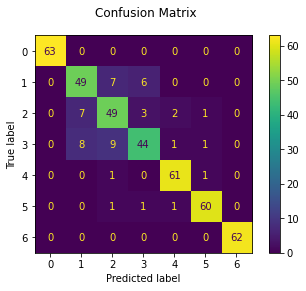

In [28]:
disp = metrics.plot_confusion_matrix(clf, X_test, y_test)
disp.figure_.suptitle("Confusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}")

In [ ]:
accuracy = np.sum(predicted==y_test)/len(predicted)
print(accuracy)